In [1]:
import os
import time
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from model import SpeechRecognition
from dataLoader import Data, collate_fn_padd
import matplotlib.pyplot as plt
device = "cuda:0"
batchSize = 64
numWorkers = 8
def train_dataloader():
    d_params = Data.parameters
    train_dataset = Data(json_path="data/train.json", **d_params)
    return DataLoader(dataset=train_dataset,
                        batch_size=batchSize,
                        num_workers=numWorkers,
                        pin_memory=True,
                        collate_fn=collate_fn_padd)
def valid_dataloader():
    d_params = Data.parameters
    valid_dataset = Data(json_path="data/test.json", **d_params)
    return DataLoader(dataset=valid_dataset,
                        batch_size=batchSize,
                        num_workers=numWorkers,
                        pin_memory=True,
                        collate_fn=collate_fn_padd)
trainLoader = train_dataloader()
validLoader = valid_dataloader()

In [2]:
def train(model, optimizer, scheduler, criterion, numEpochs=10, title="Model"):
    trnLoss = []
    valLoss = []
    for epoch in range(numEpochs):
        model.train()
        tmpTrnLoss = []
        for i, (spectrograms, labels, input_lengths, label_lengths) in enumerate(trainLoader): 
            spectrograms, labels = spectrograms.to(device), labels.to(device)
            bs = spectrograms.shape[0]
            hidden = model._init_hidden(bs)
            hn, c0 = hidden[0].to(device), hidden[1].to(device)
            output, _ = model(spectrograms, (hn, c0))
            output = F.log_softmax(output, dim=2)
            loss = criterion(output, labels, input_lengths, label_lengths)
            tmpTrnLoss.append(loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        trnLoss.append(torch.mean(torch.tensor(tmpTrnLoss)))
        print(f"Train Epoch [{epoch+1}/{numEpochs}], Loss: {loss.item():.4f}")
        model.eval()
        tmpValLoss = []
        with torch.no_grad():
            for i, (spectrograms, labels, input_lengths, label_lengths) in enumerate(validLoader):
                spectrograms, labels = spectrograms.to(device), labels.to(device)
                bs = spectrograms.shape[0]
                hidden = model._init_hidden(bs)
                hn, c0 = hidden[0].to(device), hidden[1].to(device)
                output, _ = model(spectrograms, (hn, c0))
                output = F.log_softmax(output, dim=2)
                loss = criterion(output, labels, input_lengths, label_lengths)
                tmpValLoss.append(loss)
            print(f"Valid Epoch [{epoch+1}/{numEpochs}], Loss: {loss.item():.4f}")
            scheduler.step(torch.mean(torch.tensor(tmpValLoss)))
            valLoss.append(torch.mean(torch.tensor(tmpValLoss)))
    return trnLoss, valLoss

In [3]:
srmodel = SpeechRecognition().to(device)
checkpoint = torch.load("speechrecognition.ckpt")
state_dict = checkpoint['state_dict']
new_state_dict = {}
for key, value in state_dict.items():
    new_key = key.replace("model.", "")
    new_state_dict[new_key] = value
srmodel.load_state_dict(new_state_dict)
optimizer = optim.AdamW(srmodel.parameters(), 1e-3)
optimizer.load_state_dict(checkpoint["optimizer_states"][-1])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min',
    factor=0.50, patience=6)
scheduler.load_state_dict(checkpoint["lr_schedulers"][-1])
criterion = nn.CTCLoss(blank=28, zero_infinity=True)
trnLoss, valLoss = train(srmodel, optimizer, scheduler, criterion, 10)

Train Epoch [1/10], Loss: 2.6455
Valid Epoch [1/10], Loss: 2.6780
Train Epoch [2/10], Loss: 2.4980
Valid Epoch [2/10], Loss: 2.5999
Train Epoch [3/10], Loss: 2.4642
Valid Epoch [3/10], Loss: 2.5744
Train Epoch [4/10], Loss: 2.3767
Valid Epoch [4/10], Loss: 2.4709
Train Epoch [5/10], Loss: 2.3331
Valid Epoch [5/10], Loss: 2.4197
Train Epoch [6/10], Loss: 2.3085
Valid Epoch [6/10], Loss: 2.4175
Train Epoch [7/10], Loss: 2.3136
Valid Epoch [7/10], Loss: 2.4023
Train Epoch [8/10], Loss: 2.2721
Valid Epoch [8/10], Loss: 2.4099
Train Epoch [9/10], Loss: 2.2861
Valid Epoch [9/10], Loss: 2.3375
Train Epoch [10/10], Loss: 2.2894
Valid Epoch [10/10], Loss: 2.3921


In [4]:
timestamp = time.strftime("%Y%m%d%H%M%S", time.localtime())
model_name = f"model_{timestamp}.pt"
torch.save(srmodel.state_dict(), f"savedModel/{model_name}")

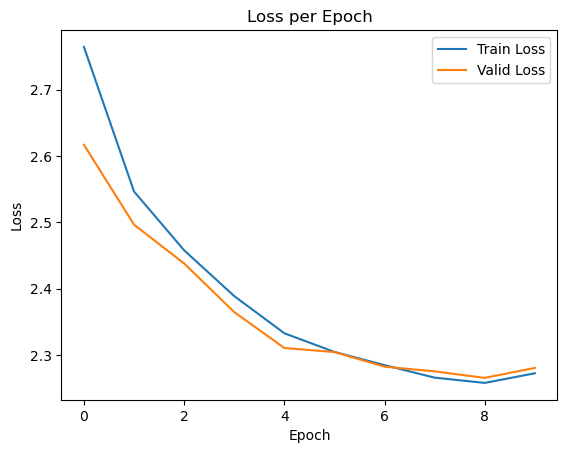

In [5]:
plt.plot([x.cpu().detach().numpy() for x in trnLoss], label = "Train Loss")
plt.plot([x.cpu().detach().numpy() for x in valLoss], label = "Valid Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [6]:
from utils import TextProcess
textprocess = TextProcess()
srmodel = SpeechRecognition().to(device)
srmodel.load_state_dict(torch.load(f"savedModel/{model_name}"))
srmodel.eval()
def valid_dataloader():
    d_params = Data.parameters
    valid_dataset = Data(json_path="data/test.json", **d_params)
    return DataLoader(dataset=valid_dataset,
                        batch_size=1,
                        num_workers=numWorkers,
                        pin_memory=True,
                        collate_fn=collate_fn_padd)
newValidLoader = valid_dataloader()    
validIter = iter(newValidLoader)
for i in range(10):
    spectrogram, label, _, ll = next(validIter)
    print("Test:",i+1)
    print("Target:")
    print(textprocess.int_to_text_sequence(label.squeeze().tolist()))
    spectrogram, label = spectrogram.to(device), label.to(device)
    bs = spectrogram.shape[0]
    hidden = srmodel._init_hidden(bs)
    hn, c0 = hidden[0].to(device), hidden[1].to(device)
    output, _ = srmodel(spectrogram, (hn, c0))
    output = F.log_softmax(output, dim=2)
    print("Output:")
    print(textprocess.int_to_text_sequence([x for x in torch.argmax(output, dim=2).squeeze().tolist() if x != 28]))
    print("")

Test: 1
Target:
this title also grants him and his family legal immunity
Output:
tes tte e aseans ane comis taor ain ca teante

Test: 2
Target:
replacement fluid is added and the blood is returned to the patient
Output:
we teeer enas aeee oris ofe

Test: 3
Target:
it also acts as a vasodilator
Output:
ebo se ais ivesedaine

Test: 4
Target:
off the ice she has appeared in several marlboro advertisements in russia
Output:
e ies seepodmiseoobor anteseiras

Test: 5
Target:
that was your fault about grayson noble said gloria coolly
Output:
ver wis  noor fo to betent porns seenobols sa ole ne oe

Test: 6
Target:
wrongfully accused received generally negative reviews
Output:
eiieciintoaoni aetefore an

Test: 7
Target:
she later got married and resided in las vegas
Output:
aatene taaer is erananiscoes

Test: 8
Target:
tours of the house and gardens are available
Output:
ces oa hosan catens ar arpaod

Test: 9
Target:
a bike track runs along the water edge
Output:
bo ted  tons ano eotea

Test: 1